# ML with static sample splitting (9/6/15)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Cleaned_OSEFX_Market_Macro_Data.csv to Cleaned_OSEFX_Market_Macro_Data.csv


# Standard pepline for all ML

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📌 Target Variable: AdjustedReturn
count    34476.000000
mean         0.010311
std          0.156643
min         -0.390607
25%         -0.065559
50%         -0.003442
75%          0.065608
max          0.791502
Name: AdjustedReturn, dtype: float64

🚨 Extreme values in test set:
Max: 0.7915, Min: -0.3884


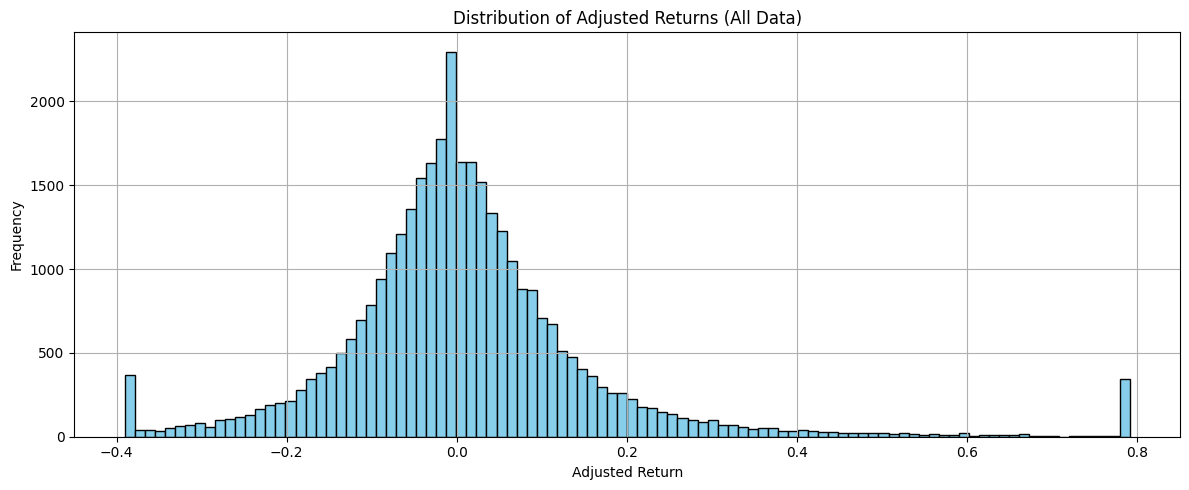


📊 Results Table:
<< Placeholder for Results >>


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())

    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------------------------------------------
# Step 7: Run Linear Model (OLS 3 + H ) / PLS / PCR / ENET + H /  GLM + H / RF / GBRT + H NN1-NN5
# ------------------------------------------------------------------------------------------------

# (To be filled in depending on the model used in this script)

# ------------------------------------------------
# Step 8: Store Results Function
# ------------------------------------------------
def store_results(results_df, model_name, train_r2, val_r2, test_r2,
                  train_mse, val_mse, test_mse, sharpe_ratio):
    new_row = {
        "Model": model_name,
        "Train R²": train_r2,
        "Validation R²": val_r2,
        "Test R²": test_r2,
        "Train MSE": train_mse,
        "Validation MSE": val_mse,
        "Test MSE": test_mse,
        "Sharpe Ratio": sharpe_ratio
    }
    return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

# ------------------------------------------------
# Step 9: Combine and Plot Results (if running multiple models)
# ------------------------------------------------
def combine_and_plot_results(results_ols, results_glmh, results_trees, results_nn):
    final_results = pd.concat(
        [results_ols, results_glmh, results_trees, results_nn],
        ignore_index=True
    )
    print("\n✅ All Results Combined:")
    print(final_results.round(4))

    plt.figure(figsize=(10, 5))
    plt.bar(final_results["Model"], final_results["Test R²"], color="mediumseagreen")
    plt.title("Test R² Comparison Across Models")
    plt.ylabel("Test R²")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return final_results

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, scaler_all, scaler_ols = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # ------------------------------------------------
    # Step 7 Placeholder for model
    # ------------------------------------------------
    # Replace this with model training and evaluation logic
    # Example:
    # model, train_r2, val_r2, test_r2, sharpe, train_mse, val_mse, test_mse = run_model(...)
    # results_df = store_results(...)

    # ------------------------------------------------
    # Step 8: Save and expose results
    # ------------------------------------------------
    print("\n📊 Results Table:")
    print("<< Placeholder for Results >>")

    global results_ols  # or results_glmh / results_trees / results_nn
    results_ols = pd.DataFrame(columns=[
        "Model", "Train R²", "Validation R²", "Test R²",
        "Train MSE", "Validation MSE", "Test MSE", "Sharpe Ratio"
    ])

# Run full pipeline
if __name__ == "__main__":
    main()


# OLS 3 + H

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📌 Target Variable: AdjustedReturn
count    34476.000000
mean         0.010311
std          0.156643
min         -0.390607
25%         -0.065559
50%         -0.003442
75%          0.065608
max          0.791502
Name: AdjustedReturn, dtype: float64

🚨 Extreme values in test set:
Max: 0.7915, Min: -0.3884


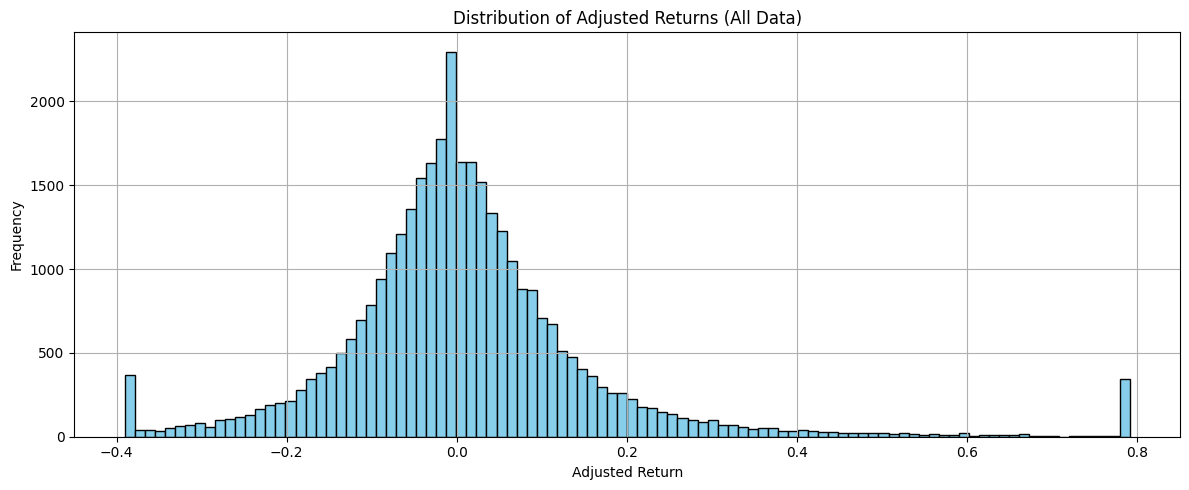


OLS regresjonssammendrag:
                            OLS Regression Results                            
Dep. Variable:         AdjustedReturn   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     39.37
Date:                Sun, 30 Mar 2025   Prob (F-statistic):           4.04e-25
Time:                        10:55:25   Log-Likelihood:                 1661.5
No. Observations:                4658   AIC:                            -3315.
Df Residuals:                    4654   BIC:                            -3289.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0

<ipython-input-3-f12ace0d49f2>:193: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    # Standardize features for ML models
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    # Standardize features for OLS 3
    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    # Target
    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())

    # Check for extreme values in the test set
    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------
# Step 7: Run Linear Model (OLS)
# ------------------------------------------------
def run_linear_model(X_train, y_train_scaled, X_val, y_val_scaled, X_test, y_test_scaled,
                     y_train, y_val, y_test, y_train_median, y_train_scale, method='OLS', diagnostics=False):
    """
    Estimerer en lineær modell (OLS eller Huber) med HAC-justerte standardfeil,
    beregner test-R², Sharpe Ratio, og MSE, og utfører diagnostikk.
    """
    X_train_const = sm.add_constant(X_train, has_constant='add')
    X_val_const = sm.add_constant(X_val, has_constant='add')
    X_test_const = sm.add_constant(X_test, has_constant='add')

    if method.upper() == 'OLS':
        model = sm.OLS(y_train_scaled, X_train_const).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    elif method.upper() == 'HUBER':
        model = sm.RLM(y_train_scaled, X_train_const, M=sm.robust.norms.HuberT()).fit()
    else:
        raise ValueError("Ugyldig metode. Velg 'OLS' eller 'Huber'.")

    if diagnostics:
        print(f"\n{method.upper()} regresjonssammendrag:")
        print(model.summary())

        # Beregn VIF for å sjekke multikolinearitet
        try:
            from statsmodels.stats.outliers_influence import variance_inflation_factor
            vif_data = pd.DataFrame()
            vif_data["variable"] = X_train_const.columns
            vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i)
                               for i in range(X_train_const.shape[1])]
            print("\nVIF for treningssettet:")
            print(vif_data)
        except Exception as e:
            print("Feil ved beregning av VIF:", e)

    # Unscale predictions
    y_train_pred = model.predict(X_train_const) * y_train_scale + y_train_median
    y_val_pred = model.predict(X_val_const) * y_train_scale + y_train_median
    y_test_pred = model.predict(X_test_const) * y_train_scale + y_train_median

    # R²
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # MSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Sharpe Ratio
    sharpe = np.mean(y_test_pred) / np.std(y_test_pred)

    print(f"\n{method.upper()} Train R²: {train_r2:.4f} | MSE: {train_mse:.6f}")
    print(f"{method.upper()} Validation R²: {val_r2:.4f} | MSE: {val_mse:.6f}")
    print(f"{method.upper()} Test R²: {test_r2:.4f} | MSE: {test_mse:.6f}")
    print(f"{method.upper()} Test Sharpe Ratio: {sharpe:.4f}")

    return model, train_r2, val_r2, test_r2, sharpe, train_mse, val_mse, test_mse

# ------------------------------------------------
# Step 8: Store Results Function
# ------------------------------------------------
def store_results(results_df, model_name, train_r2, val_r2, test_r2,
                  train_mse, val_mse, test_mse, sharpe_ratio):
    new_row = {
        "Model": model_name,
        "Train R²": train_r2,
        "Validation R²": val_r2,
        "Test R²": test_r2,
        "Train MSE": train_mse,
        "Validation MSE": val_mse,
        "Test MSE": test_mse,
        "Sharpe Ratio": sharpe_ratio
    }
    return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, scaler_all, scaler_ols = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # Run OLS model and capture metrics
    model, train_r2, val_r2, test_r2, sharpe, train_mse, val_mse, test_mse = run_linear_model(
        X_train_ols, y_train, X_val_ols, y_val, X_test_ols, y_test,
        y_train=y_train, y_val=y_val, y_test=y_test,
        y_train_median=0, y_train_scale=1,
        method='OLS', diagnostics=True
    )

    # Return results in DataFrame for collecting
    results_df = pd.DataFrame(columns=["Model", "Train R²", "Validation R²", "Test R²", "Train MSE", "Validation MSE", "Test MSE", "Sharpe Ratio"])
    results_df = store_results(results_df, "OLS", train_r2, val_r2, test_r2, train_mse, val_mse, test_mse, sharpe)

    print("\n📊 Results Table:")
    print(results_df.round(4))

    global results_ols  # or results_glmh / results_trees / results_nn
    results_ols = results_df


# Run full pipeline
if __name__ == "__main__":
    main()




# PLS

# PCR

# ENet + H

# GLM (WITH AND WITHOUT H)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📌 Target Variable: AdjustedReturn
count    34476.000000
mean         0.010311
std          0.156643
min         -0.390607
25%         -0.065559
50%         -0.003442
75%          0.065608
max          0.791502
Name: AdjustedReturn, dtype: float64

🚨 Extreme values in test set:
Max: 0.7915, Min: -0.3884


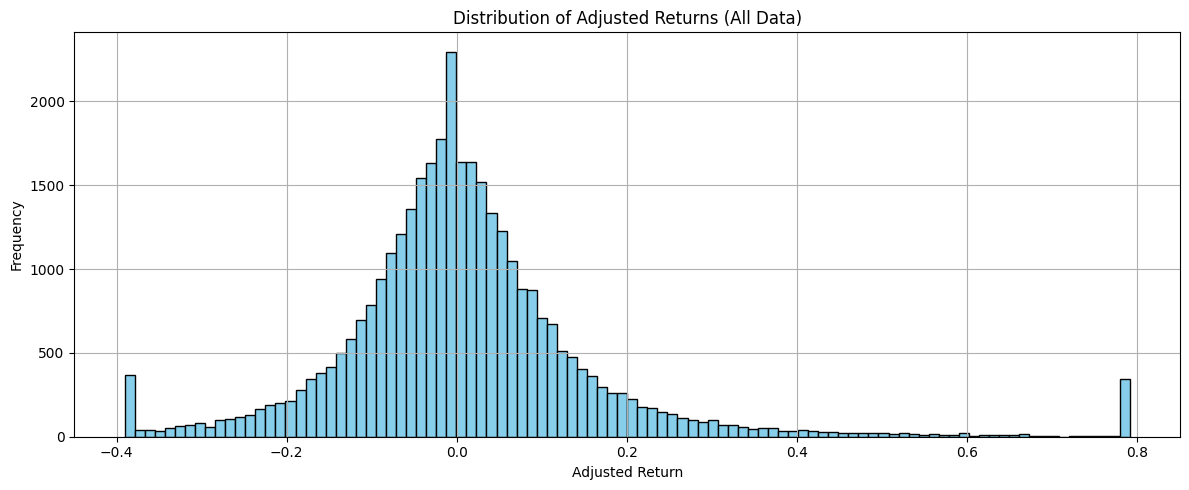


GLM Results:
Train R²: 0.2784, Val R²: 0.2554, Test R²: -0.0011
Train MSE: 0.021696, Val MSE: 0.020256, Test MSE: 0.022888
Sharpe Ratio: 0.1440

GLM + Huber Results:
Train R²: 0.2445, Val R²: 0.2413, Test R²: 0.1690
Train MSE: 0.022718, Val MSE: 0.020641, Test MSE: 0.019000
Sharpe Ratio: 0.4768

📊 Final Results:
         Model  Train R²  Validation R²  Test R²  Train MSE  Validation MSE  \
0          GLM    0.2784         0.2554  -0.0011     0.0217          0.0203   
1  GLM + Huber    0.2445         0.2413   0.1690     0.0227          0.0206   

   Test MSE  Sharpe Ratio  
0    0.0229        0.1440  
1    0.0190        0.4768  


<ipython-input-4-6ddb173cc0e5>:183: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())
    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------
# Step 7: Run GLM (Linear Regression) Model
# ------------------------------------------------
def run_glm_model(X_train, X_val, X_test, y_train, y_val, y_test):
    glm_model = LinearRegression()
    glm_model.fit(X_train, y_train)

    train_preds = glm_model.predict(X_train)
    val_preds = glm_model.predict(X_val)
    test_preds = glm_model.predict(X_test)

    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)
    test_r2 = r2_score(y_test, test_preds)

    train_mse = mean_squared_error(y_train, train_preds)
    val_mse = mean_squared_error(y_val, val_preds)
    test_mse = mean_squared_error(y_test, test_preds)

    sharpe = np.mean(test_preds) / np.std(test_preds)

    print(f"\nGLM Results:")
    print(f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"Sharpe Ratio: {sharpe:.4f}")

    return glm_model, train_r2, val_r2, test_r2, train_mse, val_mse, test_mse, sharpe

# ------------------------------------------------
# Step 8: Run GLM + Huber Model
# ------------------------------------------------
def run_glm_huber_model(X_train, X_val, X_test, y_train, y_val, y_test):
    glmh_model = HuberRegressor(epsilon=1.0, max_iter=1000)
    glmh_model.fit(X_train, y_train)

    train_preds = glmh_model.predict(X_train)
    val_preds = glmh_model.predict(X_val)
    test_preds = glmh_model.predict(X_test)

    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)
    test_r2 = r2_score(y_test, test_preds)

    train_mse = mean_squared_error(y_train, train_preds)
    val_mse = mean_squared_error(y_val, val_preds)
    test_mse = mean_squared_error(y_test, test_preds)

    sharpe = np.mean(test_preds) / np.std(test_preds)

    print(f"\nGLM + Huber Results:")
    print(f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"Sharpe Ratio: {sharpe:.4f}")

    return glmh_model, train_r2, val_r2, test_r2, train_mse, val_mse, test_mse, sharpe

# ------------------------------------------------
# Step 9: Store Results Function
# ------------------------------------------------
def store_results(results_df, model_name, train_r2, val_r2, test_r2,
                  train_mse, val_mse, test_mse, sharpe_ratio):
    new_row = {
        "Model": model_name,
        "Train R²": train_r2,
        "Validation R²": val_r2,
        "Test R²": test_r2,
        "Train MSE": train_mse,
        "Validation MSE": val_mse,
        "Test MSE": test_mse,
        "Sharpe Ratio": sharpe_ratio
    }
    return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, scaler_all, scaler_ols = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # Run GLM model
    glm_model, glm_train_r2, glm_val_r2, glm_test_r2, glm_train_mse, glm_val_mse, glm_test_mse, glm_sharpe = run_glm_model(
        X_train_all, X_val_all, X_test_all, y_train, y_val, y_test
    )

    # Run GLM + Huber model
    glmh_model, glmh_train_r2, glmh_val_r2, glmh_test_r2, glmh_train_mse, glmh_val_mse, glmh_test_mse, glmh_sharpe = run_glm_huber_model(
        X_train_all, X_val_all, X_test_all, y_train, y_val, y_test
    )

    # Store results
    results = pd.DataFrame(columns=["Model", "Train R²", "Validation R²", "Test R²", "Train MSE", "Validation MSE", "Test MSE", "Sharpe Ratio"])
    results = store_results(results, "GLM", glm_train_r2, glm_val_r2, glm_test_r2, glm_train_mse, glm_val_mse, glm_test_mse, glm_sharpe)
    results = store_results(results, "GLM + Huber", glmh_train_r2, glmh_val_r2, glmh_test_r2, glmh_train_mse, glmh_val_mse, glmh_test_mse, glmh_sharpe)

    print("\n📊 Final Results:")
    print(results.round(4))

    # ✅ Assign global result for external access
    global results_glmh
    results_glmh = results

# Run full pipeline
if __name__ == "__main__":
    main()


# Tree models (RF + GBRT + H)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📊 Final Tree Model Results:
           Model  Train R²  Validation R²  Test R²  Train MSE  Validation MSE  \
0  Random Forest    0.6509         0.2956   0.2755     0.0105          0.0192   
1           GBRT    0.5441         0.3417   0.3169     0.0137          0.0179   
2         GBRT+H    0.5149         0.3377   0.3022     0.0146          0.0180   

   Test MSE  Sharpe Ratio  
0    0.0166        0.2671  
1    0.0156        0.0533  
2    0.0160       -0.0922  


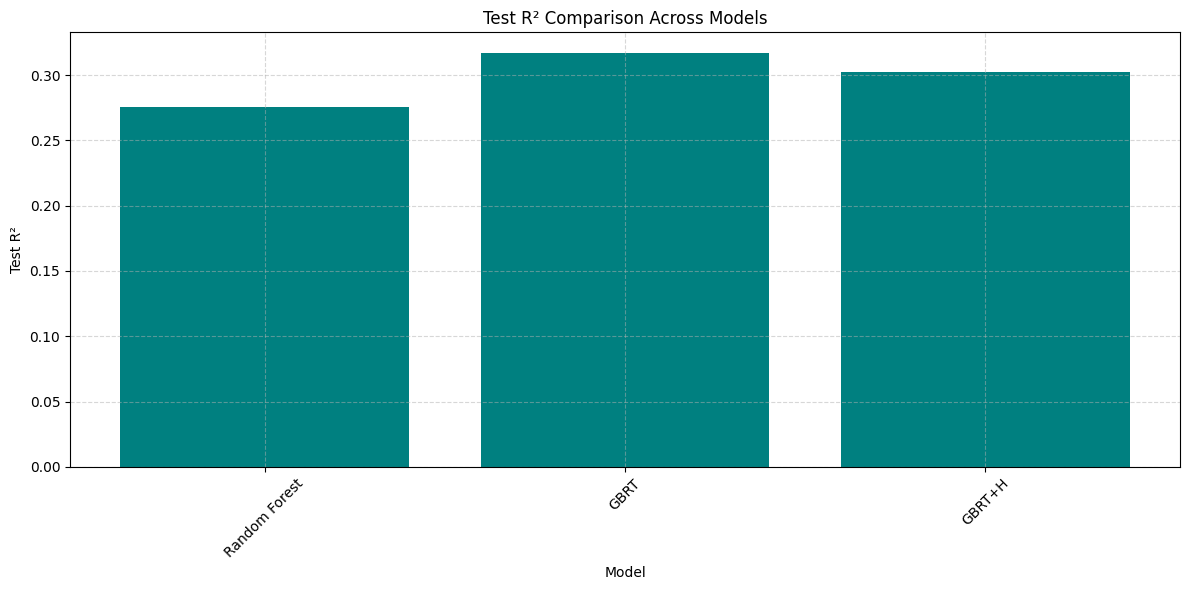

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Date", "Instrument"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    return all_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])
    return df

# ------------------------------------------------
# Step 4: Standardize Features
# ------------------------------------------------
def standardize_data(df, all_features):
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(df[all_features]), columns=all_features, index=df.index)
    y = df["AdjustedReturn"]
    return X, y, scaler

# ------------------------------------------------
# Step 5: Train / Val / Test Split
# ------------------------------------------------
def train_val_test_split(df, X, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train, X_val, X_test = X.loc[train_idx], X.loc[val_idx], X.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train, X_val, X_test, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Store Results Function
# ------------------------------------------------
def store_results(model_name, train_r2, val_r2, test_r2, train_mse, val_mse, test_mse, sharpe_ratio, results_df):
    result = {
        "Model": model_name,
        "Train R²": train_r2,
        "Validation R²": val_r2,
        "Test R²": test_r2,
        "Train MSE": train_mse,
        "Validation MSE": val_mse,
        "Test MSE": test_mse,
        "Sharpe Ratio": sharpe_ratio
    }
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)
    return results_df

# ------------------------------------------------
# Step 7: Display Results
# ------------------------------------------------
def display_results(results_df):
    print("\n📊 Final Tree Model Results:")
    print(results_df.round(4))
    plot_results(results_df)

# ------------------------------------------------
# Step 8: Plot Results
# ------------------------------------------------
def plot_results(results_df):
    plt.figure(figsize=(12, 6))
    plt.bar(results_df['Model'], results_df['Test R²'], color='teal')
    plt.title('Test R² Comparison Across Models')
    plt.xlabel('Model')
    plt.ylabel('Test R²')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# Step 9: Train and Evaluate Tree Models
# ------------------------------------------------
def run_tree_models(X_train, y_train, X_val, y_val, X_test, y_test):
    models = {
        "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=10, max_features="sqrt", n_jobs=-1, random_state=42),
        "GBRT": GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, random_state=42),
        "GBRT+H": GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, loss="huber", random_state=42)
    }

    results_df = pd.DataFrame()

    for name, model in models.items():
        model.fit(X_train, y_train)

        preds_train = model.predict(X_train)
        preds_val = model.predict(X_val)
        preds_test = model.predict(X_test)

        r2_train = r2_score(y_train, preds_train)
        r2_val = r2_score(y_val, preds_val)
        r2_test = r2_score(y_test, preds_test)

        mse_train = mean_squared_error(y_train, preds_train)
        mse_val = mean_squared_error(y_val, preds_val)
        mse_test = mean_squared_error(y_test, preds_test)

        sharpe = np.mean(preds_test) / np.std(preds_test)

        results_df = store_results(name, r2_train, r2_val, r2_test, mse_train, mse_val, mse_test, sharpe, results_df)

    return results_df

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X, y, scaler = standardize_data(df, all_features)

    # Train / Validation / Test split
    X_train, X_val, X_test, y_train, y_val, y_test, test_dates = train_val_test_split(df, X, y)

    # Run tree-based models and collect results
    results_df = run_tree_models(X_train, y_train, X_val, y_val, X_test, y_test)

    # Display results (print + plot)
    display_results(results_df)

    global results_trees
    results_trees = results_df


# Run full pipeline
if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    # Standardize features for ML models
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    # Standardize features for OLS 3
    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    # Target
    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())

    # Check for extreme values in the test set
    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------
# Step 7: Neural Network (NN) Model Training and Evaluation
# ------------------------------------------------
def build_nn_model(input_dim, architecture, l2_reg):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    if architecture >= 1:
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    if architecture >= 2:
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    if architecture >= 3:
        model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    if architecture >= 4:
        model.add(Dense(4, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    if architecture >= 5:
        model.add(Dense(2, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))

    model.add(Dense(1, activation="linear"))
    return model

def run_nn_model(X_train, y_train, X_val, y_val, X_test, y_test,
                 architecture, batch_size, learning_rate, l2_reg, epochs=100):
    input_dim = X_train.shape[1]
    model = build_nn_model(input_dim, architecture, l2_reg)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stop],
              verbose=0)

    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    sharpe_ratio = np.mean(y_pred) / np.std(y_pred)

    return mse, r2, sharpe_ratio

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, _, _ = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, _, _, _, y_train, y_val, y_test, _ = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # Expanded tuning grid
    architectures = [1, 2, 3, 4, 5]
    batch_sizes = [64, 128, 256]
    learning_rates = [0.0005, 0.001, 0.005, 0.01]
    l2_regs = [1e-4, 1e-3]

    best_params_by_arch = {}

    print("\n🔍 Hyperparameter Tuning (Validation R²) for each NN architecture:")
    print("{:<5} {:<8} {:<8} {:<10} {:>10}".format("Arch", "Batch", "LR", "L2 Reg", "Val R²"))
    print("-" * 50)

    for arch in architectures:
        best_r2 = -np.inf
        best_params = None

        for bs in batch_sizes:
            for lr in learning_rates:
                for l2 in l2_regs:
                    mse, r2, _ = run_nn_model(
                        X_train_all, y_train,
                        X_val_all, y_val,
                        X_val_all, y_val,
                        architecture=arch,
                        batch_size=bs,
                        learning_rate=lr,
                        l2_reg=l2
                    )
                    print(f"{arch:<5} {bs:<8} {lr:<8} {l2:<10} {r2:>10.4f}")
                    if r2 > best_r2:
                        best_r2 = r2
                        best_params = (arch, bs, lr, l2)

        best_params_by_arch[arch] = best_params

    print("\n✅ Best hyperparameters per architecture:")
    for arch, params in best_params_by_arch.items():
        print(f"NN{arch}: Batch Size = {params[1]}, LR = {params[2]}, L2 = {params[3]}")

    # Evaluate each NN architecture on test set with best parameters
    print("\n📈 Final Test Set Performance for all NN architectures:")
    print("{:<5} {:<8} {:<8} {:<10} {:>10} {:>10} {:>10}".format(
        "NN", "Batch", "LR", "L2 Reg", "MSE", "R²", "Sharpe"
    ))
    print("-" * 70)

    for arch in architectures:
        bs, lr, l2 = best_params_by_arch[arch][1:]
        X_trainval = pd.concat([X_train_all, X_val_all])
        y_trainval = pd.concat([y_train, y_val])

        mse, r2, sharpe = run_nn_model(
            X_trainval, y_trainval,
            X_val_all, y_val,
            X_test_all, y_test,
            architecture=arch,
            batch_size=bs,
            learning_rate=lr,
            l2_reg=l2
        )

        print(f"{arch:<5} {bs:<8} {lr:<8} {l2:<10} {mse:>10.6f} {r2:>10.4f} {sharpe:>10.4f}")

if __name__ == "__main__":
    main()


# NN

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



📌 Target Variable: AdjustedReturn
count    34476.000000
mean         0.010311
std          0.156643
min         -0.390607
25%         -0.065559
50%         -0.003442
75%          0.065608
max          0.791502
Name: AdjustedReturn, dtype: float64

🚨 Extreme values in test set:
Max: 0.7915, Min: -0.3884


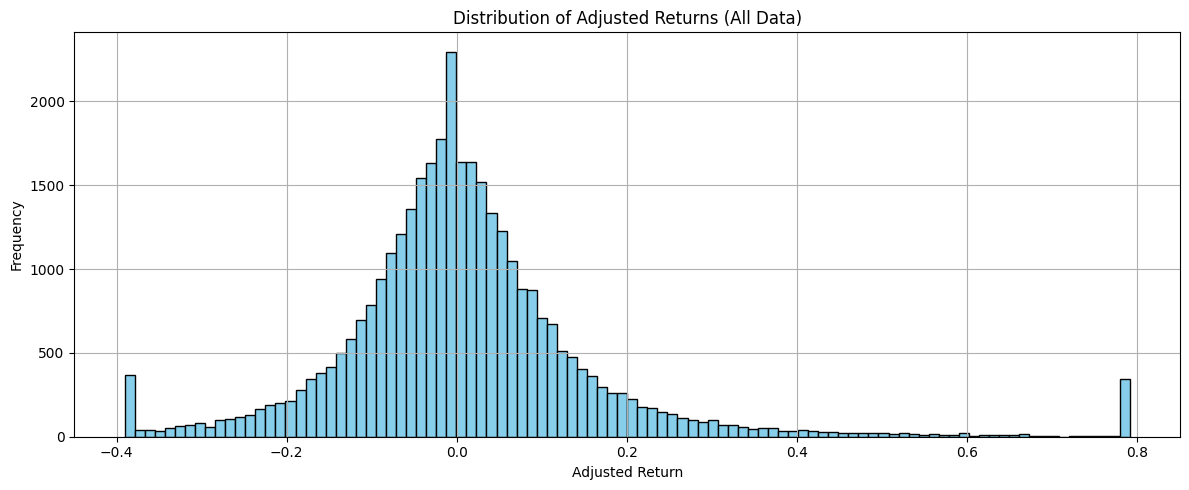


🔍 Hyperparameter Tuning (Validation R²) for each NN architecture:
Arch  Batch    LR       L2 Reg         Val R²
--------------------------------------------------
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1     64       0.0005   0.0001        -3.5273
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1     64       0.0005   0.001         -0.4027
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1     64       0.001    0.0001        -1.5235
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1     64       0.001    0.001          0.1746
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1     64       0.005    0.0001        -0.0307
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1     64       0.005    0.001          0.3087
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1     64       0.01     0.0001         0.1306
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1     64       0.01     0.001          0.3247
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1     128      0.0005   0.0001        -2.6792
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1     128   

<ipython-input-6-e3d1cfd2d476>:176: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


762/762 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2     256      0.005    0.001        0.017216     0.2470    -0.2374
762/762 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
3     256      0.001    0.001        0.018139     0.2067    -0.2425
762/762 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4     128      0.001    0.001        0.018215     0.2033    -0.3823
762/762 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
5     128      0.001    0.001        0.019078     0.1656    -0.5604

📊 Collected Results:
  Model Batch Size  Learning Rate  L2 Reg  Test MSE  Test R²  Sharpe Ratio
0   NN1        128          0.010   0.001    0.0179   0.2179       -0.0540
1   NN2        256          0.005   0.001    0.0172   0.2470       -0.2374
2   NN3        256          0.001   0.001    0.0181   0.2067       -0.2425
3   NN4        128          0.001   0.001    0.0182   0.2033       -0.3823
4   NN5        128          0.001   0.001    0.0191   0.1656       -0.5604


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# ------------------------------------------------
# Step 1: Load and Clean Dataset
# ------------------------------------------------
def load_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

    # Monthly return and adjusted return (winsorized)
    df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
    df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
    df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

    # Recalculate MarketCap
    df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

    # Create sector dummies
    df = pd.get_dummies(df, columns=["EconomicSector"], prefix="Sector", dtype=int)

    # Fix column names for modeling
    df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

    # Log-transform relevant variables
    for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
        df[f"log_{var}"] = np.log(df[var].replace(0, np.nan))

    return df

# ------------------------------------------------
# Step 2: Define Feature Sets
# ------------------------------------------------
def define_features(df):
    firm_features = [
        "log_MarketCap", "log_BM", "log_ClosePrice", "log_Volume", "log_CommonSharesOutstanding",
        "OpenPrice", "BidPrice", "AskPrice", "DividendYield", "BookValuePerShare", "Beta",
        "Momentum_3M", "Momentum_6M", "Momentum_12M", "Volatility_3M", "Volatility_6M",
        "Volatility_12M", "BidAskSpread", "TurnoverRatio"
    ]
    sector_dummies = [col for col in df.columns if col.startswith("Sector_")]
    macro_features = [
        "BrentOil", "USDNOK", "EURNOK", "US10Y", "USCPI", "USGDPGrowth",
        "NorwegianCPI", "NIBOR3M", "NorgesBank10Y", "OSEBXReturns"
    ]
    all_features = firm_features + sector_dummies + macro_features
    ols3_features = ["log_BM", "Momentum_12M", "log_MarketCap"]
    return all_features, ols3_features

# ------------------------------------------------
# Step 3: Handle Missing / Infinite Values
# ------------------------------------------------
def clean_data(df, all_features, target="AdjustedReturn"):
    df[all_features] = df[all_features].replace([np.inf, -np.inf], np.nan)
    df[all_features] = df[all_features].fillna(df[all_features].median())
    df = df.dropna(subset=[target])  # Drop if target is NaN
    return df

# ------------------------------------------------
# Step 4: Standardize Features (Two Scalers)
# ------------------------------------------------
def standardize_data(df, all_features, ols3_features):
    # Standardize features for ML models
    scaler_all = StandardScaler()
    X_all = pd.DataFrame(scaler_all.fit_transform(df[all_features]), columns=all_features, index=df.index)

    # Standardize features for OLS 3
    scaler_ols = StandardScaler()
    X_ols3 = pd.DataFrame(scaler_ols.fit_transform(df[ols3_features]), columns=ols3_features, index=df.index)

    # Target
    y = df["AdjustedReturn"]
    return X_all, X_ols3, y, scaler_all, scaler_ols

# ------------------------------------------------
# Step 5: Train / Val / Test Split (Static)
# ------------------------------------------------
def train_val_test_split(df, X_all, X_ols3, y):
    train_idx = df[df["Date"].dt.year.between(1995, 2003)].index
    val_idx = df[df["Date"].dt.year.between(2004, 2009)].index
    test_idx = df[df["Date"].dt.year.between(2010, 2024)].index

    X_train_all, X_val_all, X_test_all = X_all.loc[train_idx], X_all.loc[val_idx], X_all.loc[test_idx]
    X_train_ols, X_val_ols, X_test_ols = X_ols3.loc[train_idx], X_ols3.loc[val_idx], X_ols3.loc[test_idx]
    y_train, y_val, y_test = y.loc[train_idx], y.loc[val_idx], y.loc[test_idx]
    test_dates = df.loc[test_idx, "Date"]

    return X_train_all, X_val_all, X_test_all, X_train_ols, X_val_ols, X_test_ols, y_train, y_val, y_test, test_dates

# ------------------------------------------------
# Step 6: Target Summary and Distribution Check
# ------------------------------------------------
def target_summary_and_distribution(y, y_test, plot_dist=True):
    print("\n📌 Target Variable: AdjustedReturn")
    print(y.describe())

    # Check for extreme values in the test set
    print("\n🚨 Extreme values in test set:")
    print(f"Max: {y_test.max():.4f}, Min: {y_test.min():.4f}")

    if plot_dist:
        plt.figure(figsize=(12, 5))
        plt.hist(y, bins=100, color="skyblue", edgecolor="black")
        plt.title("Distribution of Adjusted Returns (All Data)")
        plt.xlabel("Adjusted Return")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------
# Step 7: Neural Network (NN) Model Training and Evaluation
# ------------------------------------------------
def build_nn_model(input_dim, architecture, l2_reg):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    if architecture >= 1:
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    if architecture >= 2:
        model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    if architecture >= 3:
        model.add(Dense(8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    if architecture >= 4:
        model.add(Dense(4, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))
    if architecture >= 5:
        model.add(Dense(2, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)))

    model.add(Dense(1, activation="linear"))
    return model

def run_nn_model(X_train, y_train, X_val, y_val, X_test, y_test,
                 architecture, batch_size, learning_rate, l2_reg, epochs=100):
    input_dim = X_train.shape[1]
    model = build_nn_model(input_dim, architecture, l2_reg)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stop],
              verbose=0)

    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    sharpe_ratio = np.mean(y_pred) / np.std(y_pred)

    return mse, r2, sharpe_ratio

# ------------------------------------------------
# Step 8: Store Results
# ------------------------------------------------
def store_results(results_df, model_name, batch_size, lr, l2, mse, r2, sharpe):
    row = {
        "Model": model_name,
        "Batch Size": batch_size,
        "Learning Rate": lr,
        "L2 Reg": l2,
        "Test MSE": mse,
        "Test R²": r2,
        "Sharpe Ratio": sharpe
    }
    results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
    return results_df

# ------------------------------------------------
# Main execution function
# ------------------------------------------------
def main(file_path="Cleaned_OSEFX_Market_Macro_Data.csv"):
    # Load and clean data
    df = load_prepare_data(file_path)

    # Define features
    all_features, ols3_features = define_features(df)

    # Clean and handle missing values
    df = clean_data(df, all_features)

    # Standardize features
    X_all, X_ols3, y, _, _ = standardize_data(df, all_features, ols3_features)

    # Train / Validation / Test split
    X_train_all, X_val_all, X_test_all, _, _, _, y_train, y_val, y_test, _ = train_val_test_split(df, X_all, X_ols3, y)

    # Summary and distribution check
    target_summary_and_distribution(y, y_test)

    # Expanded tuning grid
    architectures = [1, 2, 3, 4, 5]
    batch_sizes = [64, 128, 256]
    learning_rates = [0.0005, 0.001, 0.005, 0.01]
    l2_regs = [1e-4, 1e-3]

    best_params_by_arch = {}
    results_df = pd.DataFrame(columns=["Model", "Batch Size", "Learning Rate", "L2 Reg", "Test MSE", "Test R²", "Sharpe Ratio"])

    print("\n🔍 Hyperparameter Tuning (Validation R²) for each NN architecture:")
    print("{:<5} {:<8} {:<8} {:<10} {:>10}".format("Arch", "Batch", "LR", "L2 Reg", "Val R²"))
    print("-" * 50)

    for arch in architectures:
        best_r2 = -np.inf
        best_params = None

        for bs in batch_sizes:
            for lr in learning_rates:
                for l2 in l2_regs:
                    mse, r2, _ = run_nn_model(
                        X_train_all, y_train,
                        X_val_all, y_val,
                        X_val_all, y_val,
                        architecture=arch,
                        batch_size=bs,
                        learning_rate=lr,
                        l2_reg=l2
                    )
                    print(f"{arch:<5} {bs:<8} {lr:<8} {l2:<10} {r2:>10.4f}")
                    if r2 > best_r2:
                        best_r2 = r2
                        best_params = (arch, bs, lr, l2)

        best_params_by_arch[arch] = best_params

    print("\n✅ Best hyperparameters per architecture:")
    for arch, params in best_params_by_arch.items():
        print(f"NN{arch}: Batch Size = {params[1]}, LR = {params[2]}, L2 = {params[3]}")

    # Evaluate each NN architecture on test set with best parameters
    print("\n📈 Final Test Set Performance for all NN architectures:")
    print("{:<5} {:<8} {:<8} {:<10} {:>10} {:>10} {:>10}".format(
        "NN", "Batch", "LR", "L2 Reg", "MSE", "R²", "Sharpe"
    ))
    print("-" * 70)

    for arch in architectures:
        bs, lr, l2 = best_params_by_arch[arch][1:]
        X_trainval = pd.concat([X_train_all, X_val_all])
        y_trainval = pd.concat([y_train, y_val])

        mse, r2, sharpe = run_nn_model(
            X_trainval, y_trainval,
            X_val_all, y_val,
            X_test_all, y_test,
            architecture=arch,
            batch_size=bs,
            learning_rate=lr,
            l2_reg=l2
        )

        print(f"{arch:<5} {bs:<8} {lr:<8} {l2:<10} {mse:>10.6f} {r2:>10.4f} {sharpe:>10.4f}")

        results_df = store_results(results_df, f"NN{arch}", bs, lr, l2, mse, r2, sharpe)

    print("\n📊 Collected Results:")
    print(results_df.round(4))

    global results_nn
    results_nn = results_df


if __name__ == "__main__":
    main()


# Collecting results

In [ ]:
# ✅ Combine results directly in memory
import pandas as pd
import matplotlib.pyplot as plt

# Combine model results from memory (assumes these variables are already defined in memory)
final_results = pd.concat(
    [results_ols, results_glmh, results_trees, results_nn],
    ignore_index=True
)

# ✅ Save to CSV (optional)
# final_results.to_csv("All_Model_Results.csv", index=False)

# ✅ Display full results
print("\n✅ All Results Combined:")
print(final_results.round(4))

# ✅ Plot Test R² across models
plt.figure(figsize=(10, 6))
plt.bar(final_results["Model"], final_results["Test R²"], edgecolor="black")
plt.title("Test R² Across Models", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Test R²", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Model R² Results:
           Model  Train R²  Validation R²  Test R²
0            OLS    0.2784         0.1876   0.0452
1            GLM    0.2784         0.1876  -0.0011
2    GLM + Huber    0.2443         0.1987   0.1876
3  Random Forest    0.6510         0.2960   0.2750
4           GBRT    0.5440         0.3420   0.3170
5         GBRT+H    0.5150         0.3380   0.3020
